In [ ]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-l_82fg54
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-l_82fg54
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-cp36-none-any.whl size=10323 sha256=8042ed9c8542c808061257953810d3dcffb07b6d0d689843ddcda1b59ef9eb57
  Stored in directory: /tmp/pip-ephem-wheel-cache-e9fues2p/wheels/63/d1/27/a208931527abb98d326d00209f46c80c9d745851d6a1defd10
Successfully built Colab-Utils


In [ ]:
import time
import math

import torch
from torch import nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import matplotlib.pyplot as plt

import coutils
from coutils import fix_random_seed, rel_error, compute_numeric_gradient, \
                    tensor_to_image, decode_captions, attention_visualizer

# for plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

In [ ]:
# Download and load serialized COCO data from coco.pt
# It contains a dictionary of
# "train_images" - resized training images (112x112)
# "val_images" - resized validation images (112x112)
# "train_captions" - tokenized and numericalized training captions
# "val_captions" - tokenized and numericalized validation captions
# "vocab" - caption vocabulary, including "idx_to_token" and "token_to_idx"
# special tokens "<START>": start, "<END>":end, "<NULL>": padding after <END>, "<UNK>": rare words

!wget http://web.eecs.umich.edu/~justincj/teaching/eecs498/coco.pt
data_dict = torch.load('coco.pt')

# print out all the keys and values from the data dictionary
for k, v in data_dict.items():
    if type(v) == torch.Tensor:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), v.keys())

num_train = data_dict['train_images'].size(0)
num_val = data_dict['val_images'].size(0)
assert data_dict['train_images'].size(0) == data_dict['train_captions'].size(0) and \
       data_dict['val_images'].size(0) == data_dict['val_captions'].size(0), \
       'shapes of data mismatch!'

print('\nTrain images shape: ', data_dict['train_images'].shape)
print('Train caption tokens shape: ', data_dict['train_captions'].shape)
print('Validation images shape: ', data_dict['val_images'].shape)
print('Validation caption tokens shape: ', data_dict['val_captions'].shape)
print('total number of caption tokens: ', len(data_dict['vocab']['idx_to_token']))
print('mappings (list) from index to caption token: ', data_dict['vocab']['idx_to_token'])
print('mappings (dict) from caption token to index: ', data_dict['vocab']['token_to_idx'])

# declare variables for special tokens
NULL_index = data_dict['vocab']['token_to_idx']['<NULL>']
START_index = data_dict['vocab']['token_to_idx']['<START>']
END_index = data_dict['vocab']['token_to_idx']['<END>']
UNK_index = data_dict['vocab']['token_to_idx']['<UNK>']

--2019-11-13 00:27:45--  http://web.eecs.umich.edu/~justincj/teaching/eecs498/coco.pt
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 396583632 (378M)
Saving to: ‘coco.pt’

coco.pt             100%[===================>] 378.21M  52.2MB/s    in 8.5s    

2019-11-13 00:27:53 (44.6 MB/s) - ‘coco.pt’ saved [396583632/396583632]

train_images <class 'torch.Tensor'> torch.Size([10000, 3, 112, 112]) torch.uint8
train_captions <class 'torch.Tensor'> torch.Size([10000, 17]) torch.int64
val_images <class 'torch.Tensor'> torch.Size([500, 3, 112, 112]) torch.uint8
val_captions <class 'torch.Tensor'> torch.Size([500, 17]) torch.int64
vocab <class 'dict'> dict_keys(['idx_to_token', 'token_to_idx'])

Train images shape:  torch.Size([10000, 3, 112, 112])
Train caption tokens shape:  torch.Size([10000, 17])
Validation images shape:  torch.Si

## Look at the data

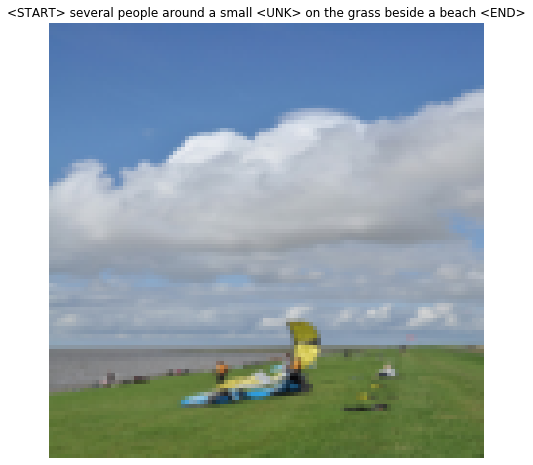

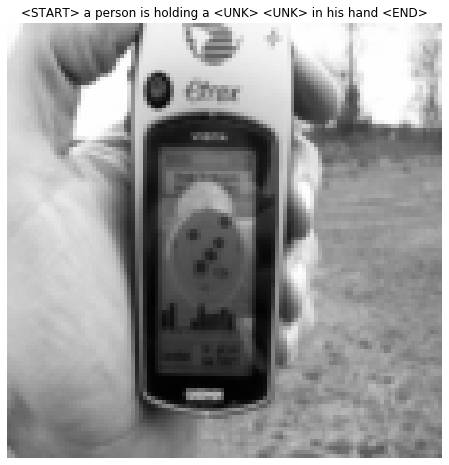

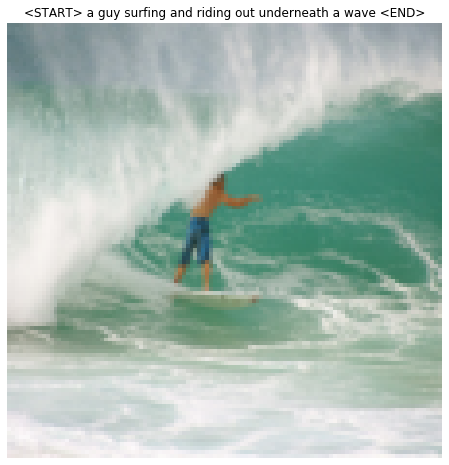

In [ ]:
# Sample a minibatch and show the reshaped 112x112 images and captions
batch_size = 3

sample_idx = torch.randint(0, num_train, (batch_size,))
sample_images = data_dict['train_images'][sample_idx]
sample_captions = data_dict['train_captions'][sample_idx]
for i in range(batch_size):
  plt.imshow(sample_images[i].permute(1, 2, 0))
  plt.axis('off')
  caption_str = decode_captions(sample_captions[i], data_dict['vocab']['idx_to_token'])
  plt.title(caption_str)
  plt.show()

# Vanilla RNN

## Vanilla RNN: step forward

In [ ]:
def rnn_step_forward(x, prev_h, Wx, Wh, b):
    """
    Run the forward pass for a single timestep of a vanilla RNN that uses a tanh
    activation function.

    The input data has dimension D, the hidden state has dimension H, and we use
    a minibatch size of N.

    Inputs:
    - x: Input data for this timestep, of shape (N, D).
    - prev_h: Hidden state from previous timestep, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases, of shape (H,)

    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - cache: Tuple of values needed for the backward pass.
    """
    next_h, cache = None, None
    h = prev_h.mm(Wh) + x.mm(Wx) + b
    next_h = torch.tanh(h)
    cache = (x, next_h, prev_h, Wh, Wx)
    return next_h, cache

In [ ]:
# test step forward function
N, D, H = 3, 10, 4

x = torch.linspace(-0.4, 0.7, steps=N*D, **to_double_cuda).reshape(N, D)
prev_h = torch.linspace(-0.2, 0.5, steps=N*H, **to_double_cuda).reshape(N, H)
Wx = torch.linspace(-0.1, 0.9, steps=D*H, **to_double_cuda).reshape(D, H)
Wh = torch.linspace(-0.3, 0.7, steps=H*H, **to_double_cuda).reshape(H, H)
b = torch.linspace(-0.2, 0.4, steps=H, **to_double_cuda)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = torch.tensor([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]], **to_double_cuda)

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  1.2584842420292407e-08


## Vanilla RNN: step backward

In [ ]:
def rnn_step_backward(dnext_h, cache):
    """
    Backward pass for a single timestep of a vanilla RNN.

    Inputs:
    - dnext_h: Gradient of loss with respect to next hidden state, of shape (N, H)
    - cache: Cache object from the forward pass

    Returns a tuple of:
    - dx: Gradients of input data, of shape (N, D)
    - dprev_h: Gradients of previous hidden state, of shape (N, H)
    - dWx: Gradients of input-to-hidden weights, of shape (D, H)
    - dWh: Gradients of hidden-to-hidden weights, of shape (H, H)
    - db: Gradients of bias vector, of shape (H,)
    """
    dx, dprev_h, dWx, dWh, db = None, None, None, None, None
    x,next_h,prev_h,Wh,Wx = cache
    d1 = 1 - next_h**2
    dx = (dnext_h * d1).mm(Wx.T)
    dprev_h = (dnext_h * d1).mm(Wh.T)
    dWx = (x.T).mm(dnext_h * d1)
    dWh = (prev_h.T).mm(dnext_h * d1)
    db = torch.sum(dnext_h * d1, dim = 0)
    return dx, dprev_h, dWx, dWh, db

In [ ]:
# test step backward function
fix_random_seed(0)
N, D, H = 4, 5, 6
x = torch.randn(N, D, **to_double_cuda)
h = torch.randn(N, H, **to_double_cuda)
Wx = torch.randn(D, H, **to_double_cuda)
Wh = torch.randn(H, H, **to_double_cuda)
b = torch.randn(H, **to_double_cuda)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = torch.randn(*out.shape, **to_double_cuda)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = compute_numeric_gradient(fx, x, dnext_h)
dprev_h_num = compute_numeric_gradient(fh, h, dnext_h)
dWx_num = compute_numeric_gradient(fWx, Wx, dnext_h)
dWh_num = compute_numeric_gradient(fWh, Wh, dnext_h)
db_num = compute_numeric_gradient(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  4.660388526969106e-10
dprev_h error:  3.259661310256616e-10
dWx error:  3.3475446140905854e-09
dWh error:  6.749797054754786e-09
db error:  2.8472153676495144e-10


## Vanilla RNN: forward


In [ ]:
def rnn_forward(x, h0, Wx, Wh, b):
    """
    Run a vanilla RNN forward on an entire sequence of data. We assume an input
    sequence composed of T vectors, each of dimension D. The RNN uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running
    the RNN forward, we return the hidden states for all timesteps.

    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D).
    - h0: Initial hidden state, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases, of shape (H,)

    Returns a tuple of:
    - h: Hidden states for the entire timeseries, of shape (N, T, H).
    - cache: Values needed in the backward pass
    """
    h, cache = None, None
    prev_h = h0
    N, T, D = x.shape
    _,H = h0.shape
    h = torch.zeros((N, T, H), device=x.device, dtype=x.dtype)
    cache = []
    for j in range(T):
        h[:, j, :], cache_sub = rnn_step_forward(x[:, j, :].clone(), prev_h, Wx, Wh, b)
        prev_h = h[:, j, :].clone()
        cache.append(cache_sub)
    return h, cache

In [ ]:
# test forward pass function
N, T, D, H = 2, 3, 4, 5

x = torch.linspace(-0.1, 0.3, steps=N*T*D, **to_double_cuda).reshape(N, T, D)
h0 = torch.linspace(-0.3, 0.1, steps=N*H, **to_double_cuda).reshape(N, H)
Wx = torch.linspace(-0.2, 0.4, steps=D*H, **to_double_cuda).reshape(D, H)
Wh = torch.linspace(-0.4, 0.1, steps=H*H, **to_double_cuda).reshape(H, H)
b = torch.linspace(-0.7, 0.1, steps=H, **to_double_cuda)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = torch.tensor([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]], **to_double_cuda)
print('h error: ', rel_error(expected_h, h))

h error:  1.5456933613305094e-07


## Vanilla RNN: backward


In [ ]:
def rnn_backward(dh, cache):
    """
    Compute the backward pass for a vanilla RNN over an entire sequence of data.

    Inputs:
    - dh: Upstream gradients of all hidden states, of shape (N, T, H). 
    
    NOTE: 'dh' contains the upstream gradients produced by the 
    individual loss functions at each timestep, *not* the gradients
    being passed between timesteps (which you'll have to compute yourself
    by calling rnn_step_backward in a loop).

    Returns a tuple of:
    - dx: Gradient of inputs, of shape (N, T, D)
    - dh0: Gradient of initial hidden state, of shape (N, H)
    - dWx: Gradient of input-to-hidden weights, of shape (D, H)
    - dWh: Gradient of hidden-to-hidden weights, of shape (H, H)
    - db: Gradient of biases, of shape (H,)
    """
    dx, dh0, dWx, dWh, db = None, None, None, None, None
    x, Wx, Wh, prev_h, next_h = cache[-1]
    _, D = x.shape
    N, T, H = dh.shape
    dx = torch.zeros((N, T, D), dtype=dh.dtype, device=dh.device)
    dh0 = torch.zeros((N, H), dtype=dh.dtype, device=dh.device)
    dWx = torch.zeros((D, H), dtype=dh.dtype, device=dh.device)
    dWh = torch.zeros((H, H), dtype=dh.dtype, device=dh.device)
    db = torch.zeros(H, dtype=dh.dtype, device=dh.device)
    dprev_h1=torch.zeros((N, H), dtype=dh.dtype, device=dh.device)
    for i in range(T-1, -1, -1):    
        dx1, dprev_h1, dWx1, dWh1, db1 = rnn_step_backward(dh[:,i,:].clone() + dprev_h1, cache.pop())    
        dx[:, i, :] = dx1    
        dh0 = dprev_h1    
        dWx = dWx+dWx1    
        dWh = dWh+dWh1    
        db = db+db1
    return dx, dh0, dWx, dWh, db

In [ ]:
# test backward pass
fix_random_seed(0)

N, D, T, H = 2, 3, 10, 5

x = torch.randn(N, T, D, **to_double_cuda)
h0 = torch.randn(N, H, **to_double_cuda)
Wx = torch.randn(D, H, **to_double_cuda)
Wh = torch.randn(H, H, **to_double_cuda)
b = torch.randn(H, **to_double_cuda)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = torch.randn(*out.shape, **to_double_cuda)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = compute_numeric_gradient(fx, x, dout)
dh0_num = compute_numeric_gradient(fh0, h0, dout)
dWx_num = compute_numeric_gradient(fWx, Wx, dout)
dWh_num = compute_numeric_gradient(fWh, Wh, dout)
db_num = compute_numeric_gradient(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  1.7013023819026014e-09
dh0 error:  2.0021232841816927e-10
dWx error:  1.3712013567135217e-09
dWh error:  1.6569656310298844e-09
db error:  2.8314824285084693e-10


## Vanilla RNN: backward with autograd


In [ ]:
# test torch autograd backward pass
fix_random_seed(0)

N, D, T, H = 2, 3, 10, 5

# set requires_grad=True
x = torch.randn(N, T, D, **to_double_cuda, requires_grad=True)
h0 = torch.randn(N, H, **to_double_cuda, requires_grad=True)
Wx = torch.randn(D, H, **to_double_cuda, requires_grad=True)
Wh = torch.randn(H, H, **to_double_cuda, requires_grad=True)
b = torch.randn(H, **to_double_cuda, requires_grad=True)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = torch.randn(*out.shape, **to_double_cuda)

# manual backward
with torch.no_grad():
  dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

# backward with autograd
out.backward(dout)
dx_auto, dh0_auto, dWx_auto, dWh_auto, db_auto = \
  x.grad, h0.grad, Wx.grad, Wh.grad, b.grad

print('dx error: ', rel_error(dx_auto, dx))
print('dh0 error: ', rel_error(dh0_auto, dh0))
print('dWx error: ', rel_error(dWx_auto, dWx))
print('dWh error: ', rel_error(dWh_auto, dWh))
print('db error: ', rel_error(db_auto, db))

dx error:  9.455508398529562e-15
dh0 error:  5.481713782464029e-16
dWx error:  5.912931393328968e-15
dWh error:  3.860601058262057e-15
db error:  4.514068576174863e-16


## RNN Module

In [ ]:
class RNN(nn.Module):
  """
  A single-layer vanilla RNN module.
  
  Arguments for initialization:
  - input_size: Input size, denoted as D before
  - hidden_size: Hidden size, denoted as H before
  """
  def __init__(self, input_size, hidden_size, device='cpu',
                dtype=torch.float32):
    """
    Initialize a RNN.
    Model parameters to initialize:
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases, of shape (H,)
    """
    super().__init__()
    
    # Register parameters
    self.Wx = Parameter(torch.randn(input_size, hidden_size,
                       device=device, dtype=dtype).div(math.sqrt(input_size)))
    self.Wh = Parameter(torch.randn(hidden_size, hidden_size,
                       device=device, dtype=dtype).div(math.sqrt(hidden_size)))
    self.b = Parameter(torch.zeros(hidden_size,
                       device=device, dtype=dtype))
    
  def forward(self, x, h0):
    """
    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D)
    - h0: Initial hidden state, of shape (N, H)

    Outputs:
    - hn: The hidden state output
    """
    hn, _ = rnn_forward(x, h0, self.Wx, self.Wh, self.b)
    return hn
  
  def step_forward(self, x, prev_h):
    """
    Inputs:
    - x: Input data for one time step, of shape (N, D)
    - prev_h: The previous hidden state, of shape (N, H)

    Outputs:
    - next_h: The next hidden state, of shape (N, H)
    """
    next_h, _ = rnn_step_forward(x, prev_h, self.Wx, self.Wh, self.b)
    return next_h

# RNN for image captioning


## Image Feature Extraction
image feature extraction via [MobileNet v2](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/).
* Vanilla RNN and LSTM: pooled CNN feature activation.
* Attention LSTM: CNN feature activation map after the last convolution layer.

In [ ]:
# !pip install torchsummary

class FeatureExtractor(object):
  """
  Image feature extraction with MobileNet.
  """
  def __init__(self, pooling=False, verbose=False,
               device='cpu', dtype=torch.float32):

    from torchvision import transforms, models
    from torchsummary import summary
    self.preprocess = transforms.Compose([
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    self.device, self.dtype = device, dtype
    self.mobilenet = models.mobilenet_v2(pretrained=True).to(device)
    self.mobilenet = nn.Sequential(*list(self.mobilenet.children())[:-1]) # Remove the last classifier
    
    # average pooling
    if pooling:
      self.mobilenet.add_module('LastAvgPool', nn.AvgPool2d(4, 4)) # input: N x 1280 x 4 x 4
    
    self.mobilenet.eval()
    if verbose:
      summary(self.mobilenet, (3, 112, 112))
  
  def extract_mobilenet_feature(self, img, verbose=False):
    """
    Inputs:
    - img: Batch of resized images, of shape N x 3 x 112 x 112

    Outputs:
    - feat: Image feature, of shape N x 1280 (pooled) or N x 1280 x 4 x 4
    """
    num_img = img.shape[0]
    
    img_prepro = []
    for i in range(num_img):
      img_prepro.append(self.preprocess(img[i].type(self.dtype).div(255.)))
    img_prepro = torch.stack(img_prepro).to(self.device)
    
    with torch.no_grad():
      feat = []
      process_batch = 500
      for b in range(math.ceil(num_img/process_batch)):
        feat.append(self.mobilenet(img_prepro[b*process_batch:(b+1)*process_batch]
                                ).squeeze(-1).squeeze(-1)) # forward and squeeze
      feat = torch.cat(feat)
      
      # add l2 normalization
      F.normalize(feat, p=2, dim=1)
    
    if verbose:
      print('Output feature shape: ', feat.shape)
    
    return feat

In [ ]:
model = FeatureExtractor(pooling=True, verbose=True, device='cuda')

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:03<00:00, 4.02MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 56, 56]             864
       BatchNorm2d-2           [-1, 32, 56, 56]              64
             ReLU6-3           [-1, 32, 56, 56]               0
            Conv2d-4           [-1, 32, 56, 56]             288
       BatchNorm2d-5           [-1, 32, 56, 56]              64
             ReLU6-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 16, 56, 56]             512
       BatchNorm2d-8           [-1, 16, 56, 56]              32
  InvertedResidual-9           [-1, 16, 56, 56]               0
           Conv2d-10           [-1, 96, 56, 56]           1,536
      BatchNorm2d-11           [-1, 96, 56, 56]             192
            ReLU6-12           [-1, 96, 56, 56]               0
           Conv2d-13           [-1, 96, 28, 28]             864
      BatchNorm2d-14           [-1, 96,

## Word embedding from scratch

In [ ]:
class WordEmbedding(nn.Module):
  """
  Simplified version of torch.nn.Embedding.

  We operate on minibatches of size N where
  each sequence has length T. We assume a vocabulary of V words, assigning each
  word to a vector of dimension D.

  Inputs:
  - x: Integer array of shape (N, T) giving indices of words. Each element idx
    of x muxt be in the range 0 <= idx < V.

  Returns a tuple of:
  - out: Array of shape (N, T, D) giving word vectors for all input words.
  """
  def __init__(self, vocab_size, embed_size,
               device='cpu', dtype=torch.float32):
      super().__init__()
      
      # Register parameters
      self.W_embed = Parameter(torch.randn(vocab_size, 
                                           embed_size,
                                           device=device, 
                                           dtype=dtype).div(math.sqrt(vocab_size)))
      
  def forward(self, x):
      out = None
      out = self.W_embed[x,:]
      return out

In [ ]:
# check implementation
N, T, V, D = 2, 4, 5, 3

x = torch.tensor([[0, 3, 1, 2], [2, 1, 0, 3]], **to_long_cuda)
W = torch.linspace(0, 1, steps=V*D, **to_double_cuda).reshape(V, D)

model_emb = WordEmbedding(V, D, **to_double_cuda)
model_emb.W_embed.data.copy_(W)
out = model_emb(x)
expected_out = torch.tensor([
 [[ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.42857143,  0.5,         0.57142857]],
 [[ 0.42857143,  0.5,         0.57142857],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429]]], **to_double_cuda)

print('out error: ', rel_error(expected_out, out))

out error:  1.9999999989472883e-08


## (Temporal) Affine layer

In [ ]:
fix_random_seed(0)

N, T, D, M = 2, 3, 4, 3

w = torch.linspace(-0.2, 0.4, steps=D*M, **to_double_cuda).reshape(D, M).permute(1, 0)
b = torch.linspace(-0.4, 0.1, steps=M, **to_double_cuda)

temporal_affine = nn.Linear(D, M).to(**to_double_cuda)
temporal_affine.weight.data.copy_(w)
temporal_affine.bias.data.copy_(b)

# For regular affine layer
x = torch.linspace(-0.1, 0.3, steps=N*D, **to_double_cuda).reshape(N, D)
out = temporal_affine(x)
print('affine layer - input shape: {}, output shape: {}'.format(x.shape, out.shape))
correct_out = torch.tensor([[-0.35584416, -0.10896104,  0.13792208],
                     [-0.31428571, -0.01753247,  0.27922078]], **to_double_cuda)

print('dx error: ', rel_error(out, correct_out))


# For temporal affine layer
x = torch.linspace(-0.1, 0.3, steps=N*T*D, **to_double_cuda).reshape(N, T, D)
out = temporal_affine(x)
print('\ntemporal affine layer - input shape: {}, output shape: {}'.format(x.shape, out.shape))
correct_out = torch.tensor([[[-0.39920949, -0.16533597,  0.06853755],
                             [-0.38656126, -0.13750988,  0.11154150],
                             [-0.37391304, -0.10968379,  0.15454545]],
                            [[-0.36126482, -0.08185771,  0.19754941],
                             [-0.34861660, -0.05403162,  0.24055336],
                             [-0.33596838, -0.02620553,  0.28355731]]], **to_double_cuda)

print('dx error: ', rel_error(out, correct_out))

affine layer - input shape: torch.Size([2, 4]), output shape: torch.Size([2, 3])
dx error:  1.4074072384500163e-07

temporal affine layer - input shape: torch.Size([2, 3, 4]), output shape: torch.Size([2, 3, 3])
dx error:  1.3725491964161247e-07


## Temporal Softmax loss


In [ ]:
def temporal_softmax_loss(x, y, ignore_index=NULL_index):
    """
    A temporal version of softmax loss for use in RNNs. We assume that we are
    making predictions over a vocabulary of size V for each timestep of a
    timeseries of length T, over a minibatch of size N. The input x gives scores
    for all vocabulary elements at all timesteps, and y gives the indices of the
    ground-truth element at each timestep. We use a cross-entropy loss at each
    timestep, *summing* the loss over all timesteps and *averaging* across the
    minibatch.

    As an additional complication, we may want to ignore the model output at some
    timesteps, since sequences of different length may have been combined into a
    minibatch and padded with NULL tokens. The optional ignore_index argument
    tells us which elements in the caption should not contribute to the loss.

    Inputs:
    - x: Input scores, of shape (N, T, V)
    - y: Ground-truth indices, of shape (N, T) where each element is in the range
         0 <= y[i, t] < V

    Returns a tuple of:
    - loss: Scalar giving loss
    """
    loss = (torch.nn.functional.cross_entropy(x.contiguous().view(-1,x.shape[2]),
                                             y.contiguous().view(-1),
                                             ignore_index=ignore_index,
                                             reduction='sum'))/x.shape[0]
   
    return loss

### Sanity check

In [ ]:
def check_loss(N, T, V, p):
    x = 0.001 * torch.randn(N, T, V, **to_double_cuda)
    y = torch.randint(V, size=(N, T), **to_long_cuda)
    mask = torch.rand(N, T, **to_double_cuda)
    y[mask > p] = 0
    print(temporal_softmax_loss(x, y).item())
  
check_loss(1000, 1, 10, 1.0)   # Should be about 2.00-2.11
check_loss(1000, 10, 10, 1.0)  # Should be about 20.6-21.0
check_loss(5000, 10, 10, 0.1) # Should be about 2.00-2.11

2.1068859657810566
20.829180466680935
2.046554829822752


## Captioning Module

In [ ]:
class CaptioningRNN(nn.Module):
    """
    A CaptioningRNN produces captions from images using a recurrent
    neural network.

    The RNN receives input vectors of size D, has a vocab size of V, works on
    sequences of length T, has an RNN hidden dimension of H, uses word vectors
    of dimension W, and operates on minibatches of size N.

    Note that we don't use any regularization for the CaptioningRNN.
    
    You will implement the `__init__` method for model initialization and
    the `forward` method first, then come back for the `sample` method later.
    """
    def __init__(self, word_to_idx, input_dim=512, wordvec_dim=128,
                 hidden_dim=128, cell_type='rnn', device='cpu', dtype=torch.float32):
        """
        Construct a new CaptioningRNN instance.

        Inputs:
        - word_to_idx: A dictionary giving the vocabulary. It contains V entries,
          and maps each string to a unique integer in the range [0, V).
        - input_dim: Dimension D of input image feature vectors.
        - wordvec_dim: Dimension W of word vectors.
        - hidden_dim: Dimension H for the hidden state of the RNN.
        - cell_type: What type of RNN to use; either 'rnn' or 'lstm'.
        - dtype: datatype to use; use float32 for training and float64 for
          numeric gradient checking.
        """
        super().__init__()
        if cell_type not in {'rnn', 'lstm', 'attention'}:
            raise ValueError('Invalid cell_type "%s"' % cell_type)

        self.cell_type = cell_type
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}

        vocab_size = len(word_to_idx)

        self._null = word_to_idx['<NULL>']
        self._start = word_to_idx.get('<START>', None)
        self._end = word_to_idx.get('<END>', None)
        
        if (cell_type =="rnn") or (cell_type =="lstm"):
          self.features = FeatureExtractor(pooling=True, verbose=False, device=device, dtype=dtype)
          #self.faff = nn.Linear(input_dim, hidden_dim).to(device=device, dtype=dtype)
        elif cell_type=='attention':
          self.features = FeatureExtractor(pooling=False, verbose=False, device=device, dtype=dtype)
          #self.faff = nn.Linear(4, hidden_dim,4,4).to(device=device, dtype=dtype)
        self.faff = nn.Linear(input_dim, hidden_dim).to(device=device, dtype=dtype)
        #self.faff1 = nn.Linear(input_dim, hidden_dim).to(device=device, dtype=dtype)
        #nn.init.kaiming_normal_(self.faff.weight).to(device=device, dtype=dtype)
        #nn.init.zeros_(self.faff.bias).to(device=device, dtype=dtype)
        #add bias
        self.embedding = WordEmbedding(vocab_size, wordvec_dim, device, dtype)
        if cell_type =="rnn":
          self.enc_dec = RNN(wordvec_dim, hidden_dim, device, dtype)
        elif cell_type =="lstm":
          self.enc_dec = LSTM(wordvec_dim, hidden_dim, device, dtype)
        elif cell_type=='attention':
            self.enc_dec = AttentionLSTM(wordvec_dim, hidden_dim, device, dtype)
        self.opaffine = nn.Linear(hidden_dim, vocab_size).to(device=device, dtype=dtype)
        #nn.init.kaiming_normal_(self.opaffine.weight).to(device=device, dtype=dtype)
        #nn.init.zeros_(self.opaffine.bias).to(device=device, dtype=dtype)
        self.hid=hidden_dim
        #add bias
    
    def forward(self):
      raise NotImplementedError
    
    def sample(self):
      raise NotImplementedError

### Forward part

In [ ]:
    def captioning_forward(self, images, captions):
        """
        Compute training-time loss for the RNN. We input images and
        ground-truth captions for those images, and use an RNN (or LSTM) to compute
        loss. The backward part will be done by torch.autograd.

        Inputs:
        - images: Input images, of shape (N, 3, 112, 112)
        - captions: Ground-truth captions; an integer array of shape (N, T + 1) where
          each element is in the range 0 <= y[i, t] < V

        Outputs:
        - loss: A scalar loss
        """
        # Cut captions into two pieces: captions_in has everything but the last word
        # and will be input to the RNN; captions_out has everything but the first
        # word and this is what we will expect the RNN to generate. These are offset
        # by one relative to each other because the RNN should produce word (t+1)
        # after receiving word t. The first element of captions_in will be the START
        # token, and the first element of captions_out will be the first word.
        captions_in = captions[:, :-1]
        captions_out = captions[:, 1:]

        loss = 0.0
        A = images.size()[0]
        features = self.features.extract_mobilenet_feature(images) # [N, 1280]
        #print(features.device)
        #if self.cell_type=='rnn'||self.cell_type=='lstm':
        if self.cell_type=='rnn' or self.cell_type=='lstm':
          h0 = self.faff(features)
        elif self.cell_type=='attention':
          """h0=torch.zeros(A,self.hid,4,4, device=features.device, dtype=features.dtype)
          for i in range(4):
            for j in range(4):
              h0[:,:,i,j]=self.faff(features[:,:,i,j])"""
          h0 = self.faff(features.permute(0,2,3,1)).permute(0,3,1,2)

        x = self.embedding(captions_in.clone())
        h = self.enc_dec.forward(x, h0)
        scores = self.opaffine(h)
        
        loss = temporal_softmax_loss(scores, captions_out.clone(), self._null)
        return loss

    CaptioningRNN.forward = captioning_forward

### Inference part

In [ ]:
    def sample_caption(self, images, max_length=15):
        """
        Run a test-time forward pass for the model, sampling captions for input
        feature vectors.

        At each timestep, we embed the current word, pass it and the previous hidden
        state to the RNN to get the next hidden state, use the hidden state to get
        scores for all vocab words, and choose the word with the highest score as
        the next word. The initial hidden state is computed by applying an affine
        transform to the image features, and the initial word is the <START>
        token.

        For LSTMs you will also have to keep track of the cell state; in that case
        the initial cell state should be zero.

        Inputs:
        - images: Input images, of shape (N, 3, 112, 112)
        - max_length: Maximum length T of generated captions

        Returns:
        - captions: Array of shape (N, max_length) giving sampled captions,
          where each element is an integer in the range [0, V). The first element
          of captions should be the first sampled word, not the <START> token.
        """
        N = images.shape[0]
        captions = self._null * images.new(N, max_length).fill_(1).long()

        if self.cell_type == 'attention':
          attn_weights_all = images.new(N, max_length, 4, 4).fill_(0).float()

        features = self.features.extract_mobilenet_feature(images)
        if self.cell_type=='rnn' or self.cell_type=='lstm':
          h = self.faff(features)
          h1 = h
          c1 = torch.zeros_like(h1, device=features.device, dtype=features.dtype)
        elif self.cell_type=='attention':
          """h=torch.zeros(N,self.hid,4,4, device=features.device, dtype=features.dtype)
          for i in range(4):
            for j in range(4):
              h[:,:,i,j]=self.faff(features[:,:,i,j])"""
          h = self.faff(features.permute(0,2,3,1)).permute(0,3,1,2)
          h1 = h
          #cell_curr = torch.zeros_like(hidden_cur, device=features.device, dtype=features.dtype)
          h1 = h1.mean(dim=(2, 3))
          c1 = h1
          attn_weights_all = attn_weights_all.to(device=features.device, dtype=features.dtype)
          #print(hidden_init.shape)
          #print(attn_weights_all.shape)
          #attn_weights_all = attn_weights_all.mean(dim=(2,3))
          #attn= torch.matmul(hidden_init, attn_weights_all.reshape(-1,4,4))


        # (1) Embedding the <START> token
        start_word_embed = self.embedding(self._start)

        
        #attn_weights=attn_weights_all
        word_embed = start_word_embed.unsqueeze(0)

        for step in range(max_length):
            # (2)
            
            if self.cell_type == 'rnn':
              h1 = self.enc_dec.step_forward(word_embed, h1)
            elif self.cell_type == 'lstm':
              h1, c1 = self.enc_dec.step_forward(word_embed, h1,c1)
            elif self.cell_type == 'attention':
              #print((attn_weights_all[:,step,:,:].squeeze().reshape(N,16,1)).shape)
              #print(attn_weights_all.shape)
              attn, attn_weights_all[:,step,:,:] = dot_product_attention(h1, h)
              #attn=torch.matmul(hidden_init.reshape(N,self.hid,16),(attn_weights[:,step,:,:].squeeze().reshape(N,16,1))).reshape(N,self.hid)
              h1, c1 = self.enc_dec.step_forward(word_embed, h1, c1, attn)

            # (3)
            step_scores = self.opaffine(h1)

            # (4)
            _, captions[:, step] = torch.max(step_scores, dim=1)

            # Embedding the output word for the next iteration
            word_embed = self.embedding(captions[:, step].clone())

        if self.cell_type == 'attention':
          return captions, attn_weights_all.cpu()
        else:
          return captions

    CaptioningRNN.sample = sample_caption

### Sanity check

In [ ]:
fix_random_seed(0)

N, D, W, H = 10, 1280, 30, 40
D_img = 112
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='rnn',
          **to_float_cuda) # use float here to be consistent with MobileNet v2


for k,v in model.named_parameters():
  # print(k, v.shape) # uncomment this to see the weight shape
  v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

images = torch.linspace(-3., 3., steps=(N * 3 * D_img * D_img),
                       **to_float_cuda).reshape(N, 3, D_img, D_img)
captions = (torch.arange(N * T, **to_long_cuda) % V).reshape(N, T)

loss = model(images, captions).item()
expected_loss = 150.6090393066

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', rel_error(torch.tensor(loss), torch.tensor(expected_loss)))

loss:  150.60902404785156
expected loss:  150.6090393066
difference:  1.0131390126844053e-07


## Image Captioning solver

In [ ]:
def CaptioningTrain(rnn_model, image_data, caption_data, lr_decay=1, **kwargs):
  """
  Run optimization to train the model.
  """
  # optimizer setup
  from torch import optim
  optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, rnn_model.parameters()),
    learning_rate) # leave betas and eps by default
  lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer,
                                             lambda epoch: lr_decay ** epoch)

  # sample minibatch data
  iter_per_epoch = math.ceil(image_data.shape[0] // batch_size)
  loss_history = []
  rnn_model.train()
  for i in range(num_epochs):
    start_t = time.time()
    for j in range(iter_per_epoch):
      images, captions = image_data[j*batch_size:(j+1)*batch_size], \
                           caption_data[j*batch_size:(j+1)*batch_size]

      loss = rnn_model(images, captions)
      optimizer.zero_grad()
      loss.backward()
      loss_history.append(loss.item())
      optimizer.step()
    end_t = time.time()
    print('(Epoch {} / {}) loss: {:.4f} time per epoch: {:.1f}s'.format(
        i, num_epochs, loss.item(), end_t-start_t))

    lr_scheduler.step()

  # plot the training losses
  plt.plot(loss_history)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Training loss history')
  plt.show()

## Overfit small data

learning rate is:  0.001
(Epoch 0 / 80) loss: 75.0497 time per epoch: 0.1s
(Epoch 1 / 80) loss: 70.1959 time per epoch: 0.1s
(Epoch 2 / 80) loss: 65.0859 time per epoch: 0.1s
(Epoch 3 / 80) loss: 60.2211 time per epoch: 0.1s
(Epoch 4 / 80) loss: 55.2516 time per epoch: 0.1s
(Epoch 5 / 80) loss: 50.8704 time per epoch: 0.1s
(Epoch 6 / 80) loss: 47.3930 time per epoch: 0.1s
(Epoch 7 / 80) loss: 44.7523 time per epoch: 0.1s
(Epoch 8 / 80) loss: 42.7839 time per epoch: 0.1s
(Epoch 9 / 80) loss: 41.3123 time per epoch: 0.1s
(Epoch 10 / 80) loss: 40.0980 time per epoch: 0.1s
(Epoch 11 / 80) loss: 39.1040 time per epoch: 0.1s
(Epoch 12 / 80) loss: 38.3358 time per epoch: 0.1s
(Epoch 13 / 80) loss: 38.0986 time per epoch: 0.1s
(Epoch 14 / 80) loss: 37.3366 time per epoch: 0.1s
(Epoch 15 / 80) loss: 36.2176 time per epoch: 0.1s
(Epoch 16 / 80) loss: 35.8566 time per epoch: 0.1s
(Epoch 17 / 80) loss: 35.0465 time per epoch: 0.1s
(Epoch 18 / 80) loss: 34.6993 time per epoch: 0.1s
(Epoch 19 / 80) 

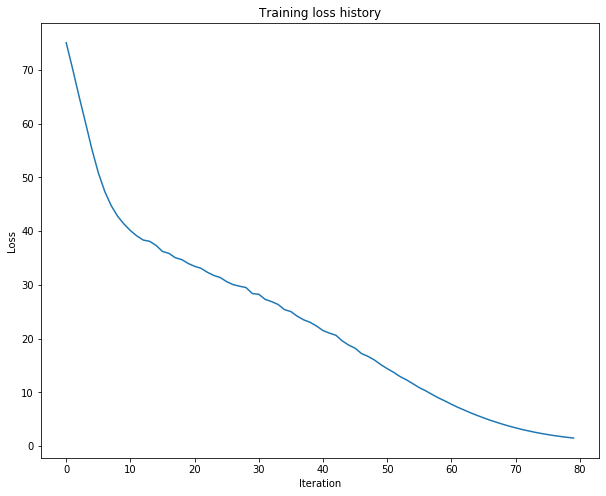

In [ ]:
fix_random_seed(0)

# data input
small_num_train = 50
sample_idx = torch.linspace(0, num_train-1, steps=small_num_train, **to_float_cuda).long()
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 80
batch_size = 50
  
# create the image captioning model
model = CaptioningRNN(
          cell_type='rnn',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  CaptioningTrain(model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

## Caption sampling

### Train the net


learning rate is:  0.001
(Epoch 0 / 60) loss: 46.8894 time per epoch: 9.7s
(Epoch 1 / 60) loss: 41.3970 time per epoch: 9.7s
(Epoch 2 / 60) loss: 38.0477 time per epoch: 9.7s
(Epoch 3 / 60) loss: 35.7648 time per epoch: 9.7s
(Epoch 4 / 60) loss: 33.6980 time per epoch: 9.8s
(Epoch 5 / 60) loss: 32.1220 time per epoch: 9.8s
(Epoch 6 / 60) loss: 30.8695 time per epoch: 9.8s
(Epoch 7 / 60) loss: 29.4635 time per epoch: 9.8s
(Epoch 8 / 60) loss: 28.0653 time per epoch: 9.8s
(Epoch 9 / 60) loss: 26.8214 time per epoch: 9.8s
(Epoch 10 / 60) loss: 25.7503 time per epoch: 9.7s
(Epoch 11 / 60) loss: 24.5555 time per epoch: 9.7s
(Epoch 12 / 60) loss: 23.3138 time per epoch: 9.7s
(Epoch 13 / 60) loss: 22.2166 time per epoch: 9.7s
(Epoch 14 / 60) loss: 21.0612 time per epoch: 9.8s
(Epoch 15 / 60) loss: 20.1966 time per epoch: 9.7s
(Epoch 16 / 60) loss: 19.8388 time per epoch: 9.7s
(Epoch 17 / 60) loss: 18.7655 time per epoch: 9.7s
(Epoch 18 / 60) loss: 17.4236 time per epoch: 9.7s
(Epoch 19 / 60) 

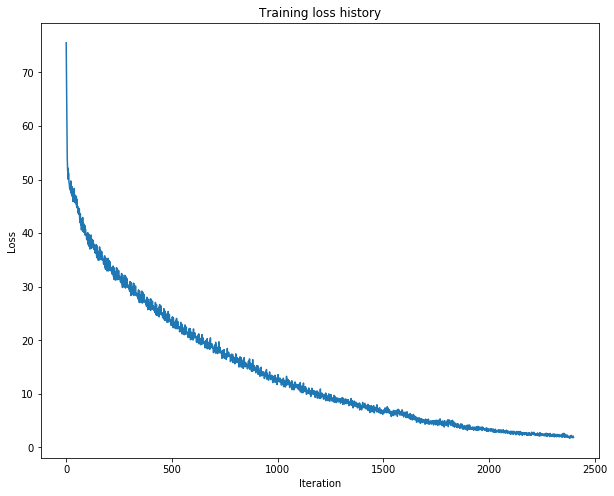

In [ ]:
fix_random_seed(0)

# data input
small_num_train = num_train
sample_idx = torch.randint(num_train, size=(small_num_train,), **to_long_cuda)
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 60
batch_size = 250

# create the image captioning model
rnn_model = CaptioningRNN(
          cell_type='rnn',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  CaptioningTrain(rnn_model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

### Test-time sampling


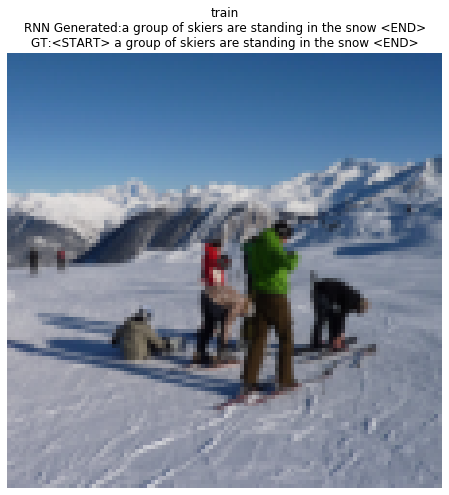

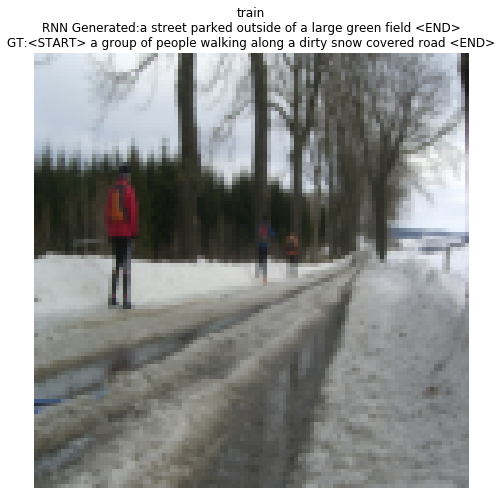

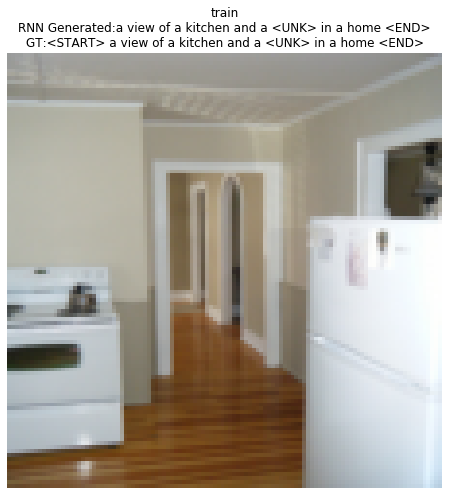

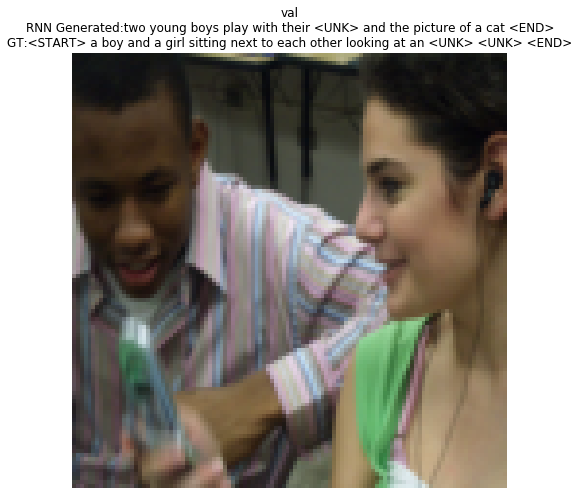

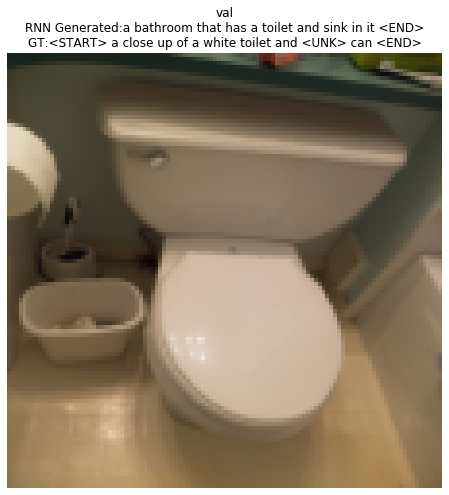

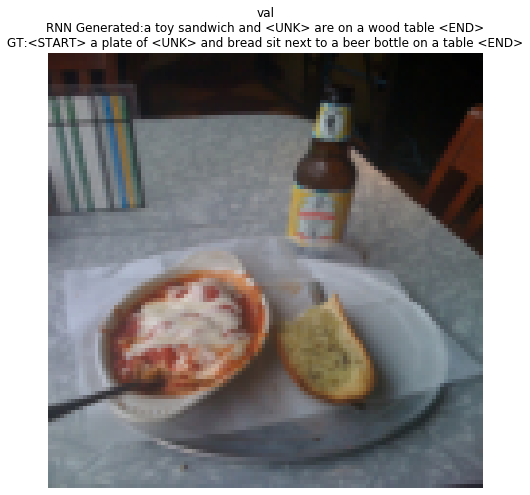

In [ ]:
# Sample a minibatch and show the reshaped 112x112 images,
# GT captions, and generated captions by your model.
batch_size = 3

for split in ['train', 'val']:
  sample_idx = torch.randint(0, num_train if split=='train' else num_val, (batch_size,))
  sample_images = data_dict[split+'_images'][sample_idx]
  sample_captions = data_dict[split+'_captions'][sample_idx]

  gt_captions = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
  rnn_model.eval()
  generated_captions = rnn_model.sample(sample_images)
  generated_captions = decode_captions(generated_captions, data_dict['vocab']['idx_to_token'])

  for i in range(batch_size):
    plt.imshow(sample_images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title('%s\nRNN Generated:%s\nGT:%s' % (split, generated_captions[i], gt_captions[i]))
    plt.show()

# Image Captioning with LSTMs

# LSTM
Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; the LSTM also maintains an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

$$
\begin{align*}
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
\end{align*}
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the code, we assume that data is stored in batches so that $X_t \in \mathbb{R}^{N\times D}$, and will work with *transposed* versions of the parameters: $W_x \in \mathbb{R}^{D \times 4H}$, $W_h \in \mathbb{R}^{H\times 4H}$ so that activations $A \in \mathbb{R}^{N\times 4H}$ can be computed efficiently as $A = X_t W_x + H_{t-1} W_h$

## LSTM: step forward

In [ ]:
def lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b, attn=None, Wattn=None):
    """
    Forward pass for a single timestep of an LSTM.

    The input data has dimension D, the hidden state has dimension H, and we use
    a minibatch size of N.

    Inputs:
    - x: Input data, of shape (N, D)
    - prev_h: Previous hidden state, of shape (N, H)
    - prev_c: previous cell state, of shape (N, H)
    - Wx: Input-to-hidden weights, of shape (D, 4H)
    - Wh: Hidden-to-hidden weights, of shape (H, 4H)
    - b: Biases, of shape (4H,)
    - attn and Wattn are for Attention LSTM only, indicate the attention input and
      embedding weights for the attention input

    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - next_c: Next cell state, of shape (N, H)
    """
    next_h, next_c = None, None

    N, H = prev_h.shape
    i = torch.zeros((N,H), device=x.device, dtype=x.dtype)
    f = torch.zeros((N,H), device=x.device, dtype=x.dtype)
    o = torch.zeros((N,H), device=x.device, dtype=x.dtype)
    g = torch.zeros((N,H), device=x.device, dtype=x.dtype)
    if attn is None:
      a = x.mm(Wx) + prev_h.mm(Wh) + b  #N*4H
    else:
      a = x.mm(Wx) + prev_h.mm(Wh) + attn.mm(Wattn) +  b  #N*4H
    i = torch.sigmoid(a[:, 0:H]) 
    f = torch.sigmoid(a[:, H:2*H]) 
    o = torch.sigmoid(a[:, 2*H:3*H]) 
    g = torch.tanh(a[:, 3*H:4*H])
    c = f * prev_c + i * g
    h = o * torch.tanh(c)
    next_c = c
    next_h = h

    return next_h, next_c

In [ ]:
N, D, H = 3, 4, 5
x = torch.linspace(-0.4, 1.2, steps=N*D, **to_double_cuda).reshape(N, D)
prev_h = torch.linspace(-0.3, 0.7, steps=N*H, **to_double_cuda).reshape(N, H)
prev_c = torch.linspace(-0.4, 0.9, steps=N*H, **to_double_cuda).reshape(N, H)
Wx = torch.linspace(-2.1, 1.3, steps=4*D*H, **to_double_cuda).reshape(D, 4 * H)
Wh = torch.linspace(-0.7, 2.2, steps=4*H*H, **to_double_cuda).reshape(H, 4 * H)
b = torch.linspace(0.3, 0.7, steps=4*H, **to_double_cuda)

next_h, next_c = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = torch.tensor([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]], **to_double_cuda)
expected_next_c = torch.tensor([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]], **to_double_cuda)

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  1.1410826302267217e-08
next_c error:  1.1628624685373283e-08


## LSTM: forward


In [ ]:
def lstm_forward(x, h0, Wx, Wh, b):
    """
    Forward pass for an LSTM over an entire sequence of data. We assume an input
    sequence composed of T vectors, each of dimension D. The LSTM uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running
    the LSTM forward, we return the hidden states for all timesteps.

    Note that the initial cell state is passed as input, but the initial cell
    state is set to zero. Also note that the cell state is not returned; it is
    an internal variable to the LSTM and is not accessed from outside.

    Inputs:
    - x: Input data, of shape (N, T, D)
    - h0: Initial hidden state, of shape (N, H)
    - Wx: Weights for input-to-hidden connections, of shape (D, 4H)
    - Wh: Weights for hidden-to-hidden connections, of shape (H, 4H)
    - b: Biases, of shape (4H,)

    Returns a tuple of:
    - h: Hidden states for all timesteps of all sequences, of shape (N, T, H)
    """
    h = None
    c0 = torch.zeros_like(h0) # we provide the intial cell state c0 here for you!

    prev_h = h0
    N, T, D = x.shape
    H = h0.shape[1]
    h = torch.zeros((N, T, H), device=x.device, dtype=x.dtype)
    c = torch.zeros((N, T, H), device=x.device, dtype=x.dtype)
    cell = torch.zeros((N, H), device=x.device, dtype=x.dtype)
    for j in range(T):
        h[:, j, :], cell = lstm_step_forward(x[:, j, :], prev_h, cell, Wx, Wh, b)
        prev_h = h[:, j, :].clone()

    return h

In [ ]:
# check implementation
N, D, H, T = 2, 5, 4, 3
x = torch.linspace(-0.4, 0.6, steps=N*T*D, **to_double_cuda).reshape(N, T, D)
h0 = torch.linspace(-0.4, 0.8, steps=N*H, **to_double_cuda).reshape(N, H)
Wx = torch.linspace(-0.2, 0.9, steps=4*D*H, **to_double_cuda).reshape(D, 4 * H)
Wh = torch.linspace(-0.3, 0.6, steps=4*H*H, **to_double_cuda).reshape(H, 4 * H)
b = torch.linspace(0.2, 0.7, steps=4*H, **to_double_cuda)

h = lstm_forward(x, h0, Wx, Wh, b)

expected_h = torch.tensor([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]], **to_double_cuda)

print('h error: ', rel_error(expected_h, h))

h error:  1.7221073441054238e-07


## LSTM Module

In [ ]:
class LSTM(nn.Module):
  """
  This is our single-layer, uni-directional LSTM module.
  
  Arguments for initialization:
  - input_size: Input size, denoted as D before
  - hidden_size: Hidden size, denoted as H before
  """
  def __init__(self, input_size, hidden_size, device='cpu',
                dtype=torch.float32):
    """
    Initialize a LSTM.
    Model parameters to initialize:
    - Wx: Weights for input-to-hidden connections, of shape (D, 4H)
    - Wh: Weights for hidden-to-hidden connections, of shape (H, 4H)
    - b: Biases, of shape (4H,)
    """
    super().__init__()
    
    # Register parameters
    self.Wx = Parameter(torch.randn(input_size, hidden_size*4,
                       device=device, dtype=dtype).div(math.sqrt(input_size)))
    self.Wh = Parameter(torch.randn(hidden_size, hidden_size*4,
                       device=device, dtype=dtype).div(math.sqrt(hidden_size)))
    self.b = Parameter(torch.zeros(hidden_size*4,
                       device=device, dtype=dtype))
    
  def forward(self, x, h0):
    """
    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D)
    - h0: Initial hidden state, of shape (N, H)

    Outputs:
    - hn: The hidden state output
    """
    hn = lstm_forward(x, h0, self.Wx, self.Wh, self.b)
    return hn
  
  def step_forward(self, x, prev_h, prev_c):
    """
    Inputs:
    - x: Input data for one time step, of shape (N, D)
    - prev_h: The previous hidden state, of shape (N, H)
    - prev_c: The previous cell state, of shape (N, H)

    Outputs:
    - next_h: The next hidden state, of shape (N, H)
    - next_c: The next cell state, of shape (N, H)
    """
    next_h, next_c = lstm_step_forward(x, prev_h, prev_c, self.Wx, self.Wh, self.b)
    return next_h, next_c

## LSTM captioning model

In [ ]:
fix_random_seed(0)

N, D, W, H = 10, 1280, 30, 40
D_img = 112
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='lstm',
          **to_float_cuda)

for k,v in model.named_parameters():
  # print(k, v.shape) # uncomment this to see the weight shape
  v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

images = torch.linspace(-3., 3., steps=(N * 3 * D_img * D_img),
                       **to_float_cuda).reshape(N, 3, D_img, D_img)
captions = (torch.arange(N * T, **to_long_cuda) % V).reshape(N, T)

loss = model(images, captions).item()
expected_loss = 146.3161468505

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', rel_error(torch.tensor(loss), torch.tensor(expected_loss)))

loss:  146.31614685058594
expected loss:  146.3161468505
difference:  0.0


## Overfit small data

learning rate is:  0.01
(Epoch 0 / 80) loss: 74.8294 time per epoch: 0.1s
(Epoch 1 / 80) loss: 71.3793 time per epoch: 0.1s
(Epoch 2 / 80) loss: 50.9300 time per epoch: 0.1s
(Epoch 3 / 80) loss: 47.2105 time per epoch: 0.1s
(Epoch 4 / 80) loss: 46.6496 time per epoch: 0.1s
(Epoch 5 / 80) loss: 44.9922 time per epoch: 0.1s
(Epoch 6 / 80) loss: 43.7903 time per epoch: 0.1s
(Epoch 7 / 80) loss: 42.0730 time per epoch: 0.1s
(Epoch 8 / 80) loss: 40.2900 time per epoch: 0.1s
(Epoch 9 / 80) loss: 38.5121 time per epoch: 0.1s
(Epoch 10 / 80) loss: 36.6386 time per epoch: 0.1s
(Epoch 11 / 80) loss: 34.5787 time per epoch: 0.1s
(Epoch 12 / 80) loss: 32.6985 time per epoch: 0.1s
(Epoch 13 / 80) loss: 30.6679 time per epoch: 0.1s
(Epoch 14 / 80) loss: 28.5078 time per epoch: 0.1s
(Epoch 15 / 80) loss: 26.3218 time per epoch: 0.1s
(Epoch 16 / 80) loss: 24.1295 time per epoch: 0.1s
(Epoch 17 / 80) loss: 21.8528 time per epoch: 0.1s
(Epoch 18 / 80) loss: 19.9651 time per epoch: 0.1s
(Epoch 19 / 80) l

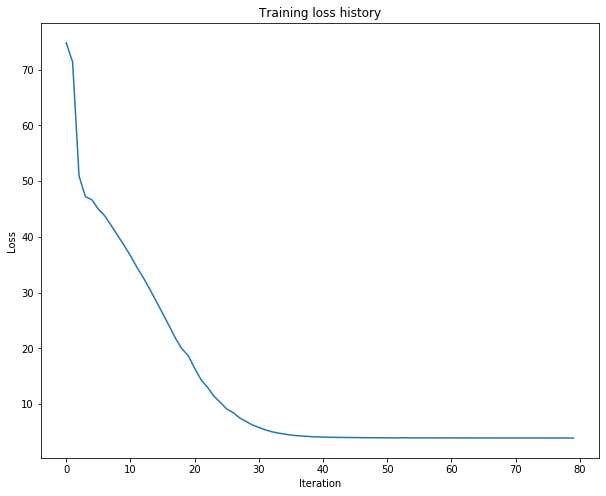

In [ ]:
fix_random_seed(0)

# data input
small_num_train = 50
sample_idx = torch.linspace(0, num_train-1, steps=small_num_train, **to_float_cuda).long()
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 80
batch_size = 50

# create the image captioning model
model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          **to_float_cuda)

for learning_rate in [1e-2]:
  print('learning rate is: ', learning_rate)
  CaptioningTrain(model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

## Caption sampling


### Train the net

learning rate is:  0.001
(Epoch 0 / 60) loss: 48.1617 time per epoch: 11.1s
(Epoch 1 / 60) loss: 43.4833 time per epoch: 11.1s
(Epoch 2 / 60) loss: 39.4039 time per epoch: 11.1s
(Epoch 3 / 60) loss: 37.3220 time per epoch: 11.1s
(Epoch 4 / 60) loss: 35.7381 time per epoch: 11.1s
(Epoch 5 / 60) loss: 34.2933 time per epoch: 11.1s
(Epoch 6 / 60) loss: 32.9798 time per epoch: 11.1s
(Epoch 7 / 60) loss: 31.8587 time per epoch: 11.2s
(Epoch 8 / 60) loss: 30.7836 time per epoch: 11.2s
(Epoch 9 / 60) loss: 29.8110 time per epoch: 11.2s
(Epoch 10 / 60) loss: 28.8604 time per epoch: 11.2s
(Epoch 11 / 60) loss: 27.9444 time per epoch: 11.2s
(Epoch 12 / 60) loss: 26.8691 time per epoch: 11.1s
(Epoch 13 / 60) loss: 25.9535 time per epoch: 11.1s
(Epoch 14 / 60) loss: 25.0340 time per epoch: 11.1s
(Epoch 15 / 60) loss: 24.1523 time per epoch: 11.1s
(Epoch 16 / 60) loss: 23.3982 time per epoch: 11.1s
(Epoch 17 / 60) loss: 22.5036 time per epoch: 11.1s
(Epoch 18 / 60) loss: 21.7340 time per epoch: 11.

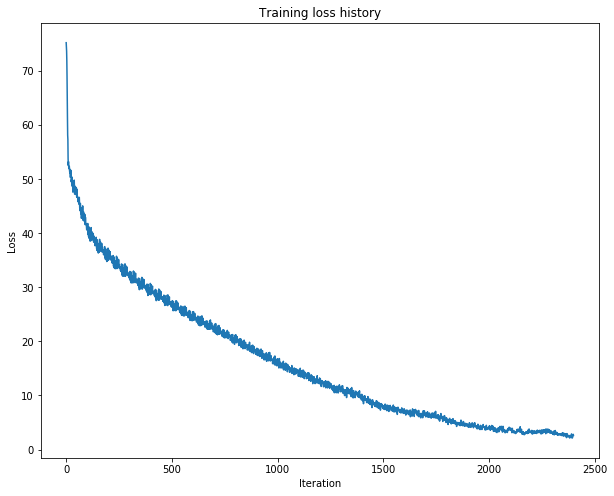

In [ ]:
fix_random_seed(0)

# data input
small_num_train = num_train
sample_idx = torch.randint(num_train, size=(small_num_train,), **to_long_cuda)
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 60
batch_size = 250

# create the image captioning model
lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  CaptioningTrain(lstm_model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

### Test-time sampling


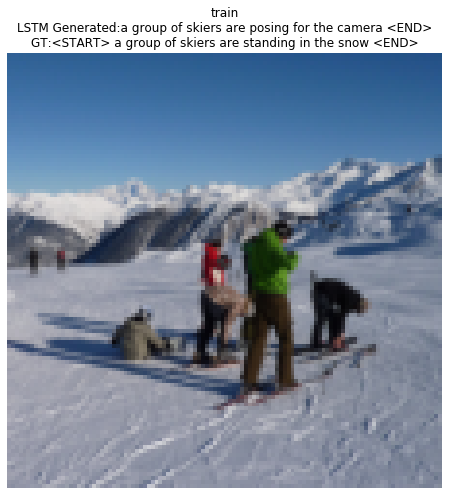

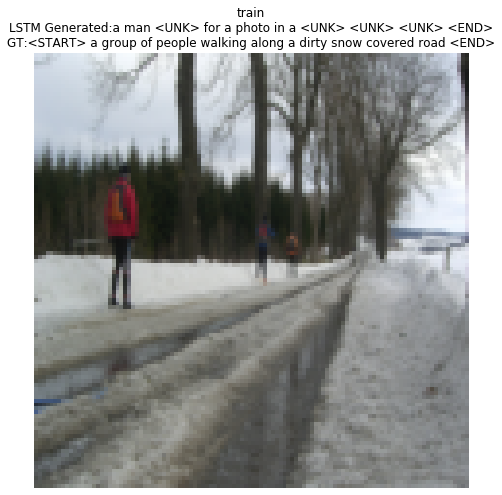

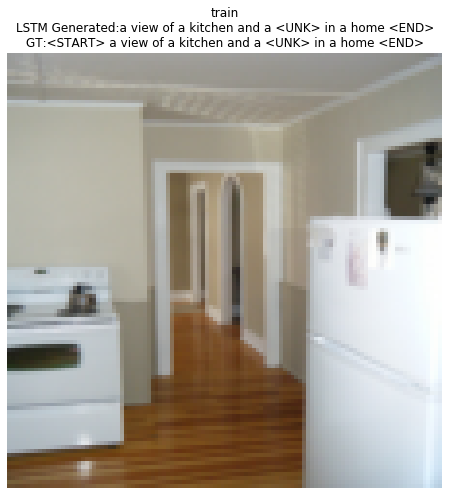

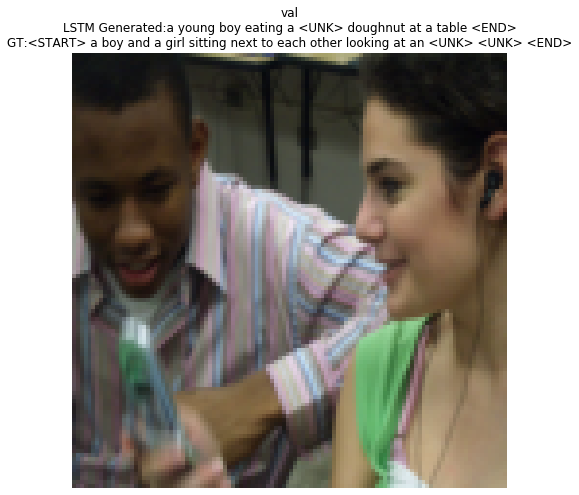

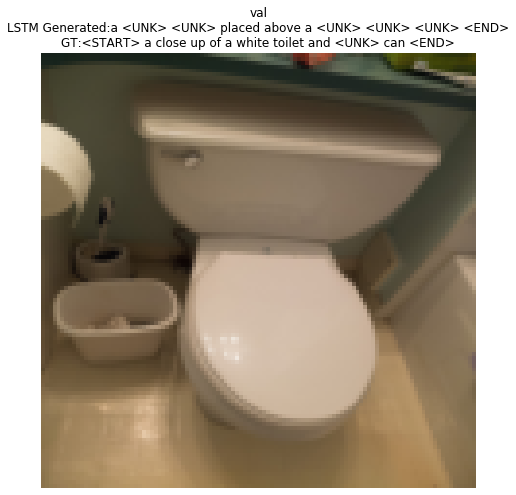

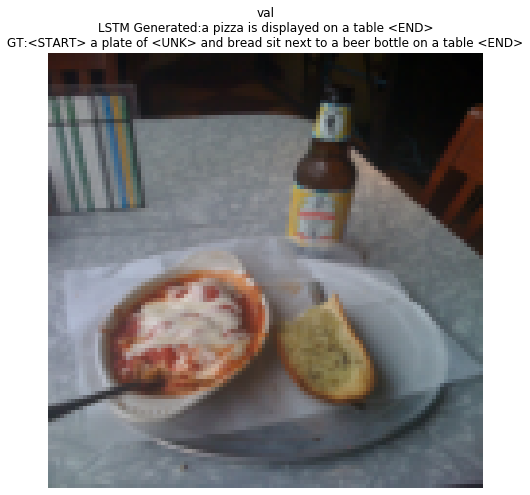

In [ ]:
# Sample a minibatch and show the reshaped 112x112 images,
# GT captions, and generated captions by your model.
batch_size = 3

for split in ['train', 'val']:
  sample_idx = torch.randint(0, num_train if split=='train' else num_val, (batch_size,))
  sample_images = data_dict[split+'_images'][sample_idx]
  sample_captions = data_dict[split+'_captions'][sample_idx]

  gt_captions = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
  lstm_model.eval()
  generated_captions = lstm_model.sample(sample_images)
  generated_captions = decode_captions(generated_captions, data_dict['vocab']['idx_to_token'])

  for i in range(batch_size):
    plt.imshow(sample_images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title('%s\nLSTM Generated:%s\nGT:%s' % (split, generated_captions[i], gt_captions[i]))
    plt.show()

# Attention LSTM
Attention LSTM essentially adds an attention input $x_{attn}^t\in\mathbb{R}^H$ into LSTM, along with $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$.

To get the attention input $x_{attn}^t$, here we adopt a method called `scaled dot-product attention`. We first project the CNN feature activation from $\mathbb{R}^{1280\times4\times4}$ to $\mathbb{R}^{H\times4\times4}$ using an affine layer. Given the projected activation $A\in \mathbb{R}^{H\times4\times4}$ and the LSTM hidden state from the previous time step $h_{t-1}$, we formuate the attention weights on $A$ at time step $t$ as $M_{attn}^t=h_{t-1}A/\sqrt{H} \in \mathbb{R}^{4\times4}$.

To simplify the formuation here, we flatten the spatial dimensions of $A$ and $M_{attn}^t$ which gives $\tilde{A}\in \mathbb{R}^{H\times16}$ and $\tilde{M^t}_{attn}=h_{t-1}A\in \mathbb{R}^{16}$.
We add a **`softmax`** activation function on $\tilde{M^t}_{attn}$ so that the attention weights at each time step are normalized and sum up to one.

The attention embedding given the attention weights is then $x_{attn}^t=\tilde{A}\tilde{M^t}_{attn} \in\mathbb{R}^H$.

## Scaled dot-product attention


In [ ]:
def dot_product_attention(prev_h, A):
    """
    A simple scaled dot-product attention layer.
    Inputs:
    - prev_h: The LSTM hidden state from the previous time step, of shape (N, H)
    - A: **Projected** CNN feature activation, of shape (N, H, 4, 4),
         where H is the LSTM hidden state size
    
    Outputs:
    - attn: Attention embedding output, of shape (N, H)
    - attn_weights: Attention weights, of shape (N, 4, 4)
    
    """
    N, H, D_a, _ = A.shape

    attn, attn_weights = None, None
    A=A.reshape(N,H, D_a*D_a)
    prev_h=prev_h.reshape(N,H,1)
    M=torch.matmul(A.permute(0,2,1),(prev_h)).to(device=A.device, dtype=A.dtype)
    attn_weights=torch.softmax(M/torch.sqrt(torch.tensor(H, device=A.device, dtype=A.dtype)), dim=1)
    #print((attn_weights.reshape(N,D_a*D_a,1)).shape)
    #print(A.shape)
    attn=torch.matmul(A,(attn_weights.reshape(N,D_a*D_a,1))).reshape(N,H)
    attn_weights=attn_weights.reshape(N,D_a,D_a)
    """for i in range(4):
      for j in range(4):
            e=prev_h.mm(A[:,:,i,j])/sqrt(A.shape[2])"""
    return attn, attn_weights

In [ ]:
# test implementation
N, H = 2, 5
D_a = 4

prev_h = torch.linspace(-0.4, 0.6, steps=N*H, **to_double_cuda).reshape(N, H)
A = torch.linspace(-0.4, 1.8, steps=N*H*D_a*D_a, **to_double_cuda).reshape(N, H, D_a, D_a)

attn, attn_weights = dot_product_attention(prev_h, A)

expected_attn = torch.tensor([[-0.29784344, -0.07645979,  0.14492386,  0.36630751,  0.58769115],
        [ 0.81412643,  1.03551008,  1.25689373,  1.47827738,  1.69966103]], **to_double_cuda)
expected_attn_weights = torch.tensor([[[0.06511126, 0.06475411, 0.06439892, 0.06404568],
         [0.06369438, 0.06334500, 0.06299754, 0.06265198],
         [0.06230832, 0.06196655, 0.06162665, 0.06128861],
         [0.06095243, 0.06061809, 0.06028559, 0.05995491]],

        [[0.05717142, 0.05784357, 0.05852362, 0.05921167],
         [0.05990781, 0.06061213, 0.06132473, 0.06204571],
         [0.06277517, 0.06351320, 0.06425991, 0.06501540],
         [0.06577977, 0.06655312, 0.06733557, 0.06812722]]], **to_double_cuda)

print('attn error: ', rel_error(expected_attn, attn))
print('attn_weights error: ', rel_error(expected_attn_weights, attn_weights))

attn error:  1.8611673497054094e-08
attn_weights error:  7.549315963595102e-08


## Attention LSTM: step forward

In [ ]:
N, D, H = 3, 4, 5

x = torch.linspace(-0.4, 1.2, steps=N*D, **to_double_cuda).reshape(N, D)
prev_h = torch.linspace(-0.3, 0.7, steps=N*H, **to_double_cuda).reshape(N, H)
prev_c = torch.linspace(-0.4, 0.9, steps=N*H, **to_double_cuda).reshape(N, H)
Wx = torch.linspace(-2.1, 1.3, steps=4*D*H, **to_double_cuda).reshape(D, 4 * H)
Wh = torch.linspace(-0.7, 2.2, steps=4*H*H, **to_double_cuda).reshape(H, 4 * H)
b = torch.linspace(0.3, 0.7, steps=4*H, **to_double_cuda)
attn = torch.linspace(0.6, 1.8, steps=N*H, **to_double_cuda).reshape(N, H)
Wattn = torch.linspace(1.3, 4.2, steps=4*H*H, **to_double_cuda).reshape(H, 4 * H)


next_h, next_c = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b, attn, Wattn)

expected_next_h = torch.tensor([
    [0.53704256, 0.59980774, 0.65596820, 0.70569729, 0.74932626],
    [0.78729857, 0.82010653, 0.84828362, 0.87235677, 0.89283167],
    [0.91017981, 0.92483119, 0.93717126, 0.94754073, 0.95623746]], **to_double_cuda)
expected_next_c = torch.tensor([
    [0.59999328, 0.69285041, 0.78570758, 0.87856479, 0.97142202],
    [1.06428558, 1.15714276, 1.24999992, 1.34285708, 1.43571424],
    [1.52857143, 1.62142857, 1.71428571, 1.80714286, 1.90000000]], **to_double_cuda)

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  7.749791467532482e-09
next_c error:  3.6613350811635177e-09


## Attention LSTM: forward


In [ ]:
def attention_forward(x, A, Wx, Wh, Wattn, b):
    """
    h0 and c0 are same initialized as the global image feature (meanpooled A)
    For simplicity, we implement scaled dot-product attention, which means in
    Eq. 4 of the paper (https://arxiv.org/pdf/1502.03044.pdf),
    f_{att}(a_i, h_{t−1}) equals to the scaled dot product of a_i and h_{t-1}.
    
    Forward pass for an LSTM over an entire sequence of data. We assume an input
    sequence composed of T vectors, each of dimension D. The LSTM uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running
    the LSTM forward, we return the hidden states for all timesteps.

    Note that the initial cell state is passed as input, but the initial cell
    state is set to zero. Also note that the cell state is not returned; it is
    an internal variable to the LSTM and is not accessed from outside.

    Inputs:
    - x: Input data, of shape (N, T, D)
    - A: **Projected** activation map, of shape (N, H, 4, 4)
    - Wx: Weights for input-to-hidden connections, of shape (D, 4H)
    - Wh: Weights for hidden-to-hidden connections, of shape (H, 4H)
    - Wattn: Weights for attention-to-hidden connections, of shape (H, 4H)
    - b: Biases, of shape (4H,)

    Returns a tuple of:
    - h: Hidden states for all timesteps of all sequences, of shape (N, T, H)
    """
    
    h = None
    
    # The initial hidden state h0 and cell state c0 are initialized differently in
    # Attention LSTM from the original LSTM and hence we provided them for you.
    h0 = A.mean(dim=(2, 3)) # Initial hidden state, of shape (N, H)
    c0 = h0 # Initial cell state, of shape (N, H)

    N, T, D = x.shape
    _, H, _, _ = A.shape
    h = torch.zeros(N, T, H, device=x.device, dtype=x.dtype)
    h1 = h0
    c1 = c0

    for i in range(T):
      attn, _ = dot_product_attention(h1,A)
      h1,c1 = lstm_step_forward(x[:,i,:], h1, c1, Wx, Wh, b, attn, Wattn)
      h[:,i,:] = h1
   
    return h

In [ ]:
N, D, H, T = 2, 5, 4, 3
D_a = 4

x = torch.linspace(-0.4, 0.6, steps=N*T*D, **to_double_cuda).reshape(N, T, D)
A = torch.linspace(-0.4, 1.8, steps=N*H*D_a*D_a, **to_double_cuda).reshape(N, H, D_a, D_a)
Wx = torch.linspace(-0.2, 0.9, steps=4*D*H, **to_double_cuda).reshape(D, 4 * H)
Wh = torch.linspace(-0.3, 0.6, steps=4*H*H, **to_double_cuda).reshape(H, 4 * H)
Wattn = torch.linspace(1.3, 4.2, steps=4*H*H, **to_double_cuda).reshape(H, 4 * H)
b = torch.linspace(0.2, 0.7, steps=4*H, **to_double_cuda)

h = attention_forward(x, A, Wx, Wh, Wattn, b)

expected_h = torch.tensor([
        [[0.56141729, 0.70274849, 0.80000386, 0.86349400],
         [0.89556391, 0.92856726, 0.94950579, 0.96281018],
         [0.96792077, 0.97535465, 0.98039623, 0.98392994]],

        [[0.95065880, 0.97135490, 0.98344373, 0.99045552],
         [0.99317679, 0.99607466, 0.99774317, 0.99870293],
         [0.99907382, 0.99946784, 0.99969426, 0.99982435]]], **to_double_cuda)

print('h error: ', rel_error(expected_h, h))

h error:  5.953926115196726e-09


## Attention LSTM Module

In [ ]:
class AttentionLSTM(nn.Module):
  """
  This is our single-layer, uni-directional Attention module.
  
  Arguments for initialization:
  - input_size: Input size, denoted as D before
  - hidden_size: Hidden size, denoted as H before
  """
  def __init__(self, input_size, hidden_size, device='cpu',
                dtype=torch.float32):
    """
    Initialize a LSTM.
    Model parameters to initialize:
    - Wx: Weights for input-to-hidden connections, of shape (D, 4H)
    - Wh: Weights for hidden-to-hidden connections, of shape (H, 4H)
    - Wattn: Weights for attention-to-hidden connections, of shape (H, 4H)
    - b: Biases, of shape (4H,)
    """
    super().__init__()
    
    # Register parameters
    self.Wx = Parameter(torch.randn(input_size, hidden_size*4,
                       device=device, dtype=dtype).div(math.sqrt(input_size)))
    self.Wh = Parameter(torch.randn(hidden_size, hidden_size*4,
                       device=device, dtype=dtype).div(math.sqrt(hidden_size)))
    self.Wattn = Parameter(torch.randn(hidden_size, hidden_size*4,
                       device=device, dtype=dtype).div(math.sqrt(hidden_size)))
    self.b = Parameter(torch.zeros(hidden_size*4,
                       device=device, dtype=dtype))
    
  def forward(self, x, A):
    """  
    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D)
    - A: The projected CNN feature activation, of shape (N, H, 4, 4)

    Outputs:
    - hn: The hidden state output
    """
    hn = attention_forward(x, A, self.Wx, self.Wh, self.Wattn, self.b)
    return hn
  
  def step_forward(self, x, prev_h, prev_c, attn):
    """
    Inputs:
    - x: Input data for one time step, of shape (N, D)
    - prev_h: The previous hidden state, of shape (N, H)
    - prev_c: The previous cell state, of shape (N, H)
    - attn: The attention embedding, of shape (N, H)

    Outputs:
    - next_h: The next hidden state, of shape (N, H)
    - next_c: The next cell state, of shape (N, H)
    """
    next_h, next_c = lstm_step_forward(x, prev_h, prev_c, self.Wx, self.Wh,
                                       self.b, attn=attn, Wattn=self.Wattn)
    return next_h, next_c

## Attention LSTM captioning model

In [ ]:
fix_random_seed(0)

N, D, W, H = 10, 1280, 30, 40
D_img = 112
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='attention',
          **to_float_cuda)

for k,v in model.named_parameters():
  # print(k, v.shape) # uncomment this to see the weight shape
  v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

images = torch.linspace(-3., 3., steps=(N * 3 * D_img * D_img),
                       **to_float_cuda).reshape(N, 3, D_img, D_img)
captions = (torch.arange(N * T, **to_long_cuda) % V).reshape(N, T)

loss = model(images, captions).item()
expected_loss = 46.9113769531

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', rel_error(torch.tensor(loss), torch.tensor(expected_loss)))

loss:  46.911376953125
expected loss:  46.9113769531
difference:  0.0


## Overfit small data

learning rate is:  0.001
(Epoch 0 / 80) loss: 75.1356 time per epoch: 0.1s
(Epoch 1 / 80) loss: 69.6820 time per epoch: 0.1s
(Epoch 2 / 80) loss: 62.9485 time per epoch: 0.1s
(Epoch 3 / 80) loss: 56.8797 time per epoch: 0.1s
(Epoch 4 / 80) loss: 52.0370 time per epoch: 0.1s
(Epoch 5 / 80) loss: 48.8553 time per epoch: 0.1s
(Epoch 6 / 80) loss: 46.5471 time per epoch: 0.1s
(Epoch 7 / 80) loss: 44.8928 time per epoch: 0.1s
(Epoch 8 / 80) loss: 43.3991 time per epoch: 0.1s
(Epoch 9 / 80) loss: 42.1603 time per epoch: 0.1s
(Epoch 10 / 80) loss: 41.0057 time per epoch: 0.1s
(Epoch 11 / 80) loss: 40.0844 time per epoch: 0.1s
(Epoch 12 / 80) loss: 39.0963 time per epoch: 0.1s
(Epoch 13 / 80) loss: 38.2450 time per epoch: 0.1s
(Epoch 14 / 80) loss: 37.3600 time per epoch: 0.1s
(Epoch 15 / 80) loss: 36.4223 time per epoch: 0.1s
(Epoch 16 / 80) loss: 35.4330 time per epoch: 0.1s
(Epoch 17 / 80) loss: 34.5597 time per epoch: 0.1s
(Epoch 18 / 80) loss: 33.7268 time per epoch: 0.1s
(Epoch 19 / 80) 

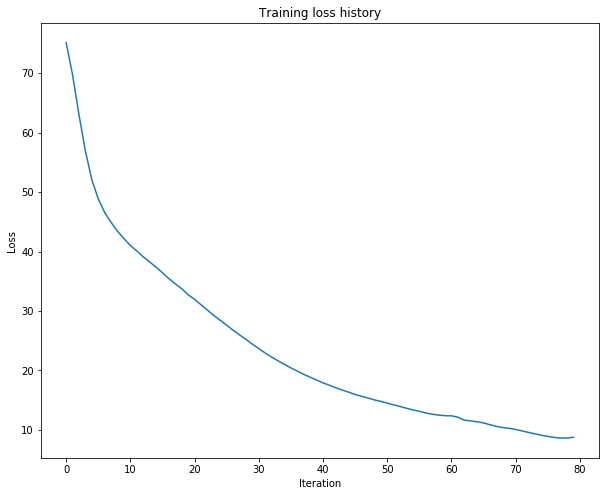

In [ ]:
fix_random_seed(0)

# data input
small_num_train = 50
sample_idx = torch.linspace(0, num_train-1, steps=small_num_train, **to_float_cuda).long()
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 80
batch_size = 50

# create the image captioning model
model = CaptioningRNN(
          cell_type='attention',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  CaptioningTrain(model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

## Caption sampling

### Train the net

learning rate is:  0.001
(Epoch 0 / 60) loss: 49.2651 time per epoch: 13.6s
(Epoch 1 / 60) loss: 47.3625 time per epoch: 13.5s
(Epoch 2 / 60) loss: 44.8060 time per epoch: 13.5s
(Epoch 3 / 60) loss: 42.1206 time per epoch: 13.6s
(Epoch 4 / 60) loss: 39.8580 time per epoch: 13.6s
(Epoch 5 / 60) loss: 37.8515 time per epoch: 13.6s
(Epoch 6 / 60) loss: 36.0832 time per epoch: 13.6s
(Epoch 7 / 60) loss: 34.3956 time per epoch: 13.7s
(Epoch 8 / 60) loss: 33.0070 time per epoch: 13.7s
(Epoch 9 / 60) loss: 31.5763 time per epoch: 13.6s
(Epoch 10 / 60) loss: 30.2330 time per epoch: 13.6s
(Epoch 11 / 60) loss: 28.8817 time per epoch: 13.6s
(Epoch 12 / 60) loss: 27.7513 time per epoch: 13.5s
(Epoch 13 / 60) loss: 26.3726 time per epoch: 13.6s
(Epoch 14 / 60) loss: 25.0237 time per epoch: 13.7s
(Epoch 15 / 60) loss: 23.7061 time per epoch: 13.7s
(Epoch 16 / 60) loss: 22.2812 time per epoch: 13.7s
(Epoch 17 / 60) loss: 21.0414 time per epoch: 13.7s
(Epoch 18 / 60) loss: 19.6368 time per epoch: 13.

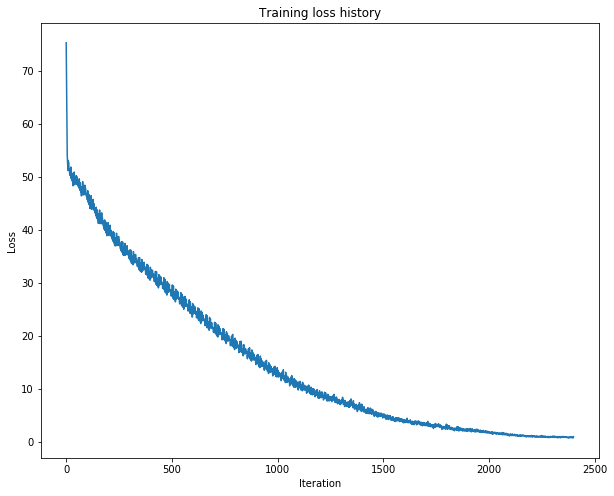

In [ ]:
fix_random_seed(0)

# data input
small_num_train = num_train
sample_idx = torch.randint(num_train, size=(small_num_train,), **to_long_cuda)
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 60
batch_size = 250

# create the image captioning model
attn_model = CaptioningRNN(
          cell_type='attention',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  CaptioningTrain(attn_model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

### Test-time sampling and visualization

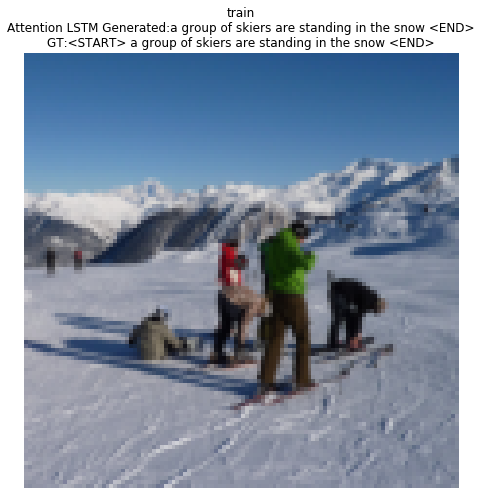

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


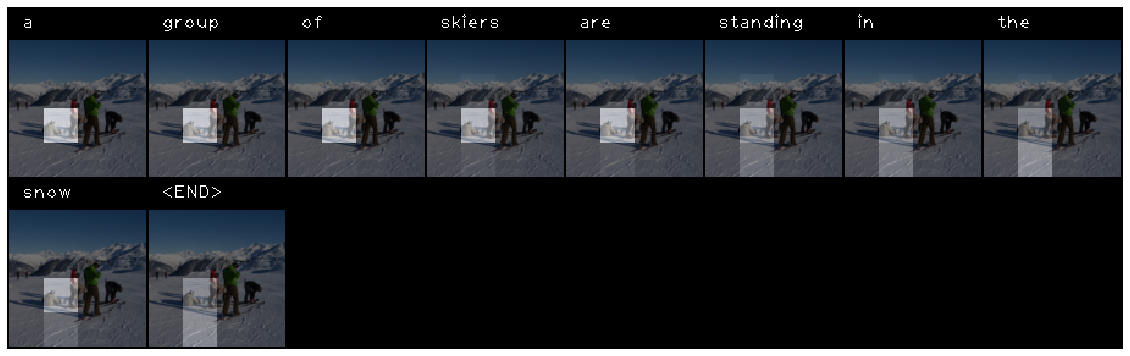

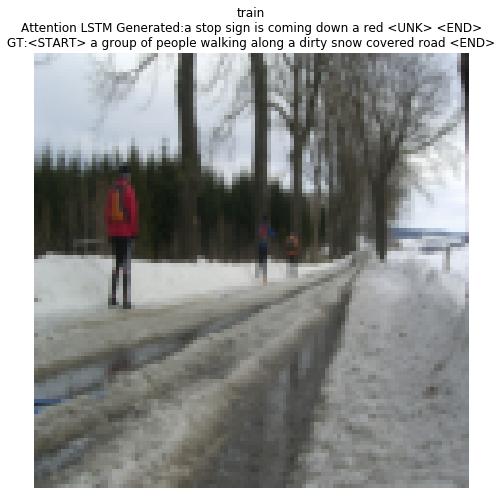

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


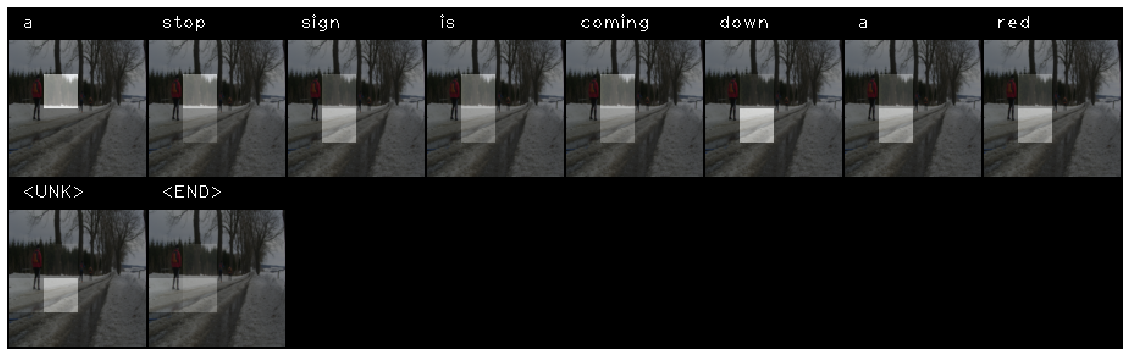

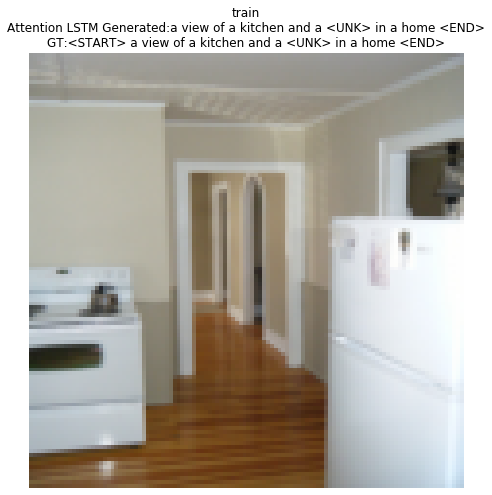

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


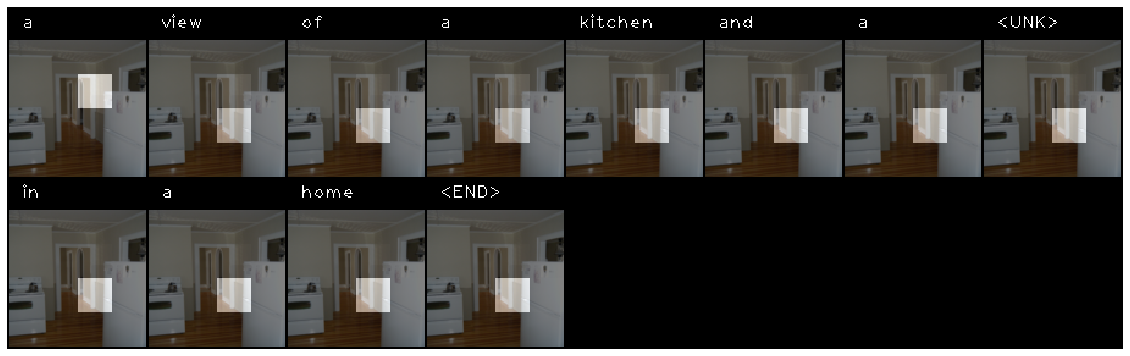

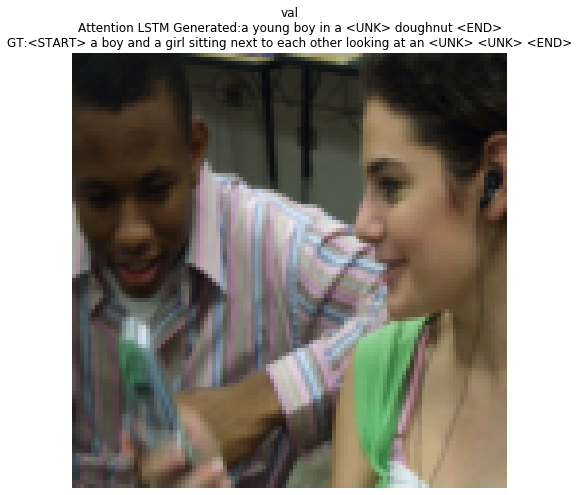

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


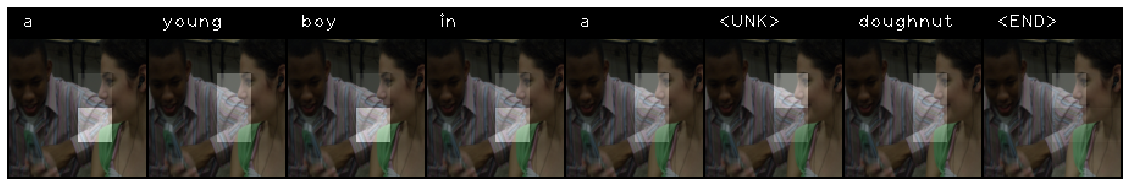

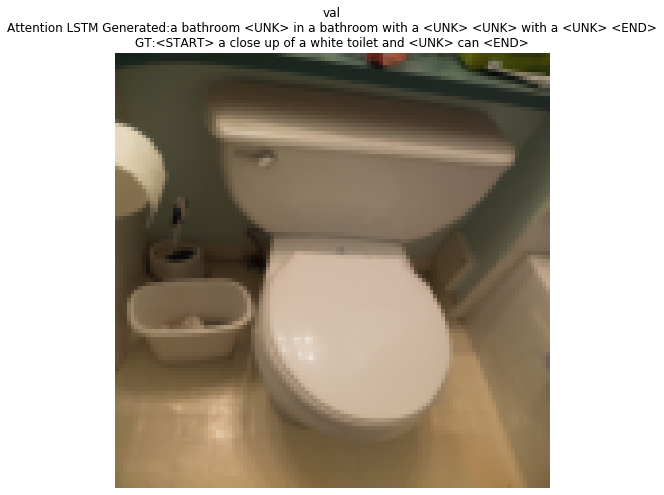

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


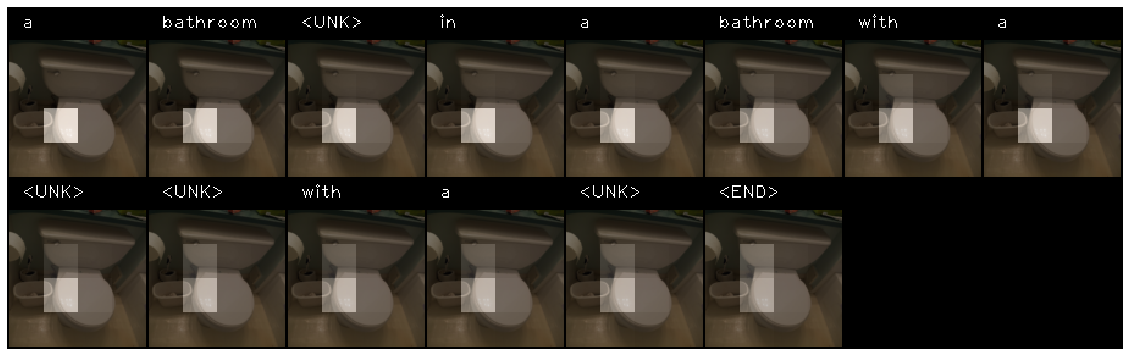

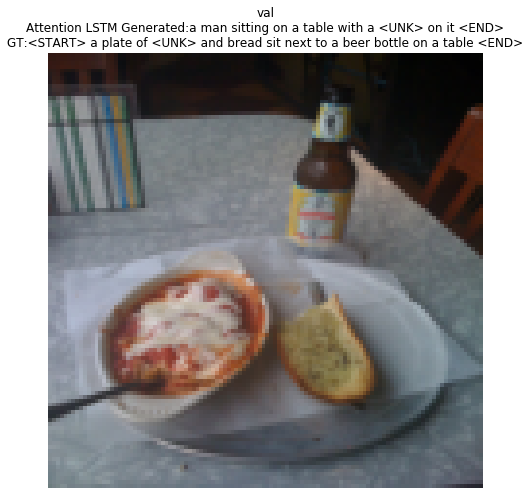

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


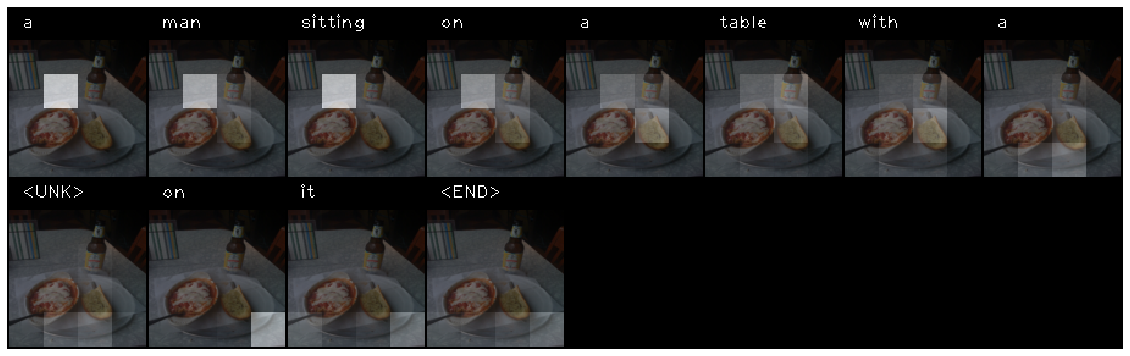

In [ ]:
# Sample a minibatch and show the reshaped 112x112 images,
# GT captions, and generated captions by your model.

batch_size = 3
from torchvision.utils import make_grid
from torchvision import transforms

for split in ['train', 'val']:
  sample_idx = torch.randint(0, num_train if split=='train' else num_val, (batch_size,))
  sample_images = data_dict[split+'_images'][sample_idx]
  sample_captions = data_dict[split+'_captions'][sample_idx]

  gt_captions = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
  attn_model.eval()
  generated_captions, attn_weights_all = attn_model.sample(sample_images)
  generated_captions = decode_captions(generated_captions, data_dict['vocab']['idx_to_token'])

  for i in range(batch_size):
    plt.imshow(sample_images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title('%s\nAttention LSTM Generated:%s\nGT:%s' % (split, generated_captions[i], gt_captions[i]))
    plt.show()
    
    tokens = generated_captions[i].split(' ')
    
    vis_attn = []
    for j in range(len(tokens)):
      img = sample_images[i]
      attn_weights = attn_weights_all[i][j]
      token = tokens[j]
      img_copy = attention_visualizer(img, attn_weights, token)
      vis_attn.append(transforms.ToTensor()(img_copy))
    
    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    vis_attn = make_grid(vis_attn, nrow=8)
    plt.imshow(torch.flip(vis_attn, dims=(0,)).permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    plt.rcParams['figure.figsize'] = (10.0, 8.0)